# Living Decisions

## Introduction

I'm about to graduate from The Fletcher School, and I want to make sure that IF I return to Boston post-covid, I find the right place to live. Enter this short, somewhat silly project. The purpose of this analysis is to determine where I should, based on factors I have identified as particularly important to my own individual happiness, including:

- **Impervious surface** - The more impervious surfaces there are, the less green space there is. I'd like a lot of green space.
- **Boston land cover** - The lower the intensity of a developed area, the better - but it does have to be developed.
- **Tree canopy** - Trees have previously been directly linked to my happiness.
- **Proximity to farmers markets** - I like to have fresh veggies and fresher baked goods every weekend.
- **Proximity to libraries** - Crucial for recouping the amount of money I expended on books in grad school.
- **Proximity to restaurants** - Having lived in a rural town with little access to restaurant food for the last year, I'd like some good ones close by.
- **Resident age** - Some of my happiness is based on making friends. While that is aboslutely not limited to a certain age bracket, it would be nice to have young-ish people to hang out with.

## The Data

In case you would like to investigate the data I used for myself, you'll find it in the `data` folder, which contains the following files:

- `data/raster/NLCD/NLCD_2016_Impervious_Boston.tif` - impervious surface raster for Boston and the surrounding area (GeoTIFF)
- `data/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif` - land cover raster for Boston and the surrounding area (GeoTIFF)
- `data/raster/NLCD/NLCD_Land_Cover_Legend.jpg` - the key for the land cover raster (JPG)
- `data/raster/NLCD/NLCD_2016_Tree_Canopy_Boston.tif` - tree canopy raster for Boston and the surrounding area (GeoTIFF)
- `data/vector/MassGIS/FARMERSMARKETS_PT/FARMERSMARKETS_PT.shp` - farmers markets of Boston (ESRI shapefile)
- `data/vector/MassGIS/LIBRARIES_PT/LIBRARIES_PT.shp` - Boston libraries (ESRI shapefile)
- `data/tabular/ACSST5Y2019.S0101/ACSST5Y2019.S0101_data_with_overlays.csv` - resident age data by zip code for Boston (.csv)
- `data/vector/Census/tl_2010_25_zcta510/tl_2010_25_zcta510.shp` - zip code boundaries shapefile for Boston (ESRI shapefile)

Data from OpenStreetMap will be added during the analysis.

## Analysis Overview

Here is a rough outline of the analysis I will perform:

1. Read in and visualize the raster datasets
2. **Impervious surface area** > reclassify for impervious surface preferences (more impervious = less desirable)
3. **Land cover** > reclassify for land cover preferences
4. **Tree canopy** > reclassify for tree canopy preferences
5. **Farmers markets** > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
6. **Libraries** > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
7. **Restaurants** > pull restaurant data from OpenStreetMap > rasterize shapefile > get euclidean distance raster > reclassify (close = more desirable)
8. **Resident age** > calculate average age by zip code > join to zip code shapefile > rasterize shapefile > reclassify (close to 30 = more desirable)
9. Calculate weighted and unweighted desirability raster from all of the reclassified rasters
10. Mask desirability rasters to the shape of Boston
11. Use zonal stats to determine the average desirability by zip code

## Import Dependencies

In [9]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage
from rasterstats import zonal_stats

## Raster Checks

Before I get started with my variables, I want to check to see if all three of the rasters I'll be using have the same metadata, and load the metadata from one of them.

In [12]:
# Open all three rasters, check that their metadata is equivalent

with rasterio.open('data/raster/NLCD/NLCD_2016_Impervious_Boston.tif') as impervious_check:
    impervious_meta = impervious_check.meta
with rasterio.open('data/raster/NLCD/NLCD_2016_Land_Cover_Boston.tif') as landcover_check:
    landcover_meta = landcover_check.meta
with rasterio.open('data/raster/NLCD/NLCD_2016_Tree_Canopy_Boston.tif') as tree_check:
    tree_meta = tree_check.meta

impervious_meta == landcover_meta == tree_meta

True

In [16]:
# Read in the impervious surface area raster and extract the relevant spatial information.

with rasterio.open('data/raster/NLCD/NLCD_2016_Impervious_Boston.tif') as raster:
    bounds = raster.bounds
    crs = raster.crs
    nodata = raster.nodata
    shape = raster.shape
    transform = raster.transform
    res = raster.res
    impervious = raster.read(1)

Great! Let's get started.

## Our map of Boston

Let's see those ZIP code tabulation areas (ZCTAs). I'm also going to convert these to the proper crs, which in this case is EPSG:6491, Massachusetts Mainland, and select only the ZCTAs which are in the Boston area (MPO = Boston Region). To get us started, we'll bring in the outline of Massachusetts - it'll help us to remove any overlap the ZCTAs have with the coastline. 

In [177]:
# Bring in the Massachusetts mainland outline and convert it to EPSG:6491.

outline = gpd.read_file('data/vector/MassGIS/OUTLINE25K_POLY/OUTLINE25K_POLY.shp')
outline.to_crs('epsg:6491', inplace=True)

Now we'll bring in the ZCTAs and clip them according to the official state outline.

In [178]:
# Bring in the ZCTA file and again convert its crs.

zips = gpd.read_file('data/vector/Census/tl_2010_25_zcta510/tl_2010_25_zcta510.shp')
zips.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

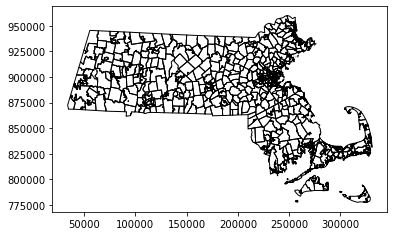

In [180]:
# Let's find the intersections!

zips_intersect = gpd.overlay(outline, zips, how='intersection')
zips_intersect.plot(facecolor='none', edgecolor='k')

Great. This will be more precise. Before we can get into just those ZCTAs that make up the Boston area, we have to extract *just* the Boston region from the MA Metropolitan Planning Organizations (MPOs).

In [179]:
# Bring in the MPO boundaries shapefile, select for Boston, and convert it to the proper crs.

mpo = gpd.read_file('data/vector/MassDOT/MPO_Boundaries/MPO_Boundaries.shp')
boston_mpo = mpo[mpo['MPO'] == 'Boston Region'].copy()
boston_mpo.to_crs('epsg:6491', inplace=True)

Beautiful. Now I know that some ZCTA boundaries could cross town (and therefore MPO) borders, so I'm going to find the centroid of each ZCTA and keep only those ZCTAs whose centroids are within the Boston Region MPO.

In [172]:
# Clip those zips!

zips_clipped = zips[zips.centroid.within(boston_mpo.geometry[10])]

<AxesSubplot:>

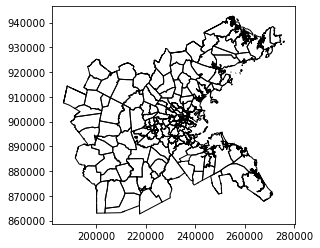

In [175]:
# Let's see 'em!

zips_clipped.plot(facecolor='None', edgecolor='Black')

Now we have a map to work with. On to the variables!

## Impervious Surface Area

I loaded the landcover raster above, so let's actually check that metadata and then see what the matrix looks like.

In [14]:
impervious_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 3322,
 'height': 3024,
 'count': 1,
 'crs': CRS.from_epsg(6491),
 'transform': Affine(30.0, 0.0, 181770.0,
        0.0, -30.0, 948390.0)}

In [17]:
impervious

array([[  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       [  0,   0,   0, ..., 127, 127, 127],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

Looks pretty solid. I'd like to see what it looks like now as a map!

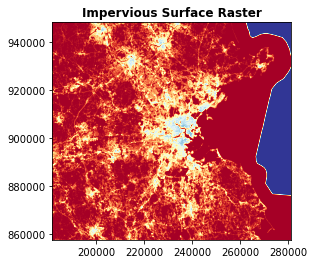

In [85]:
show(impervious, title="Impervious Surface Raster", transform=transform, cmap='RdYlBu')
plt.show()

The values in this raster tell us the percentage of the pixel area that's covered by impervious surfaces. I'm going to reclassify the Impervious Surface Raster to my own tastes - I don't want to live in water (<1% impervious), but I also want to see things that aren't asphalt and experience less flooding. I'd also like to vote for green infrastructure with my feet.

| Min Imperviousness (Inclusive) | Max Imperviousness (Exclusive) |   Suitability Level   | Suitability Score |
| :----------------------------: | :----------------------------: | :-------------------: | :---------------: |
|              ...               |                1%              | Very low suitability  |          1        |
|               1%               |                10%             | Very high suitability |          5        |
|               10%              |                20%             |    High suitability   |          4        |
|               20%              |                60%             |   Medium suitability  |          3        |
|               60%              |                100%            |    Low suitability    |          2        |
|               100%             |                ...             | Very low suitability  |          1        |

I'm also going to classify those pesky 127's as very low suitability - they're not in Boston!

In [100]:
# Create a new impervious surface array

impervious_reclass = np.full(shape, np.NaN)

# Reclassify that surface!

impervious_reclass[impervious < 1] = 1
impervious_reclass[(impervious >= 1) & (impervious < 10)] = 5
impervious_reclass[(impervious >= 10) & (impervious < 20)] = 4
impervious_reclass[(impervious >= 20) & (impervious < 60)] = 3
impervious_reclass[(impervious >= 60) & (impervious < 100)] = 2
impervious_reclass[impervious >= 100] = 1

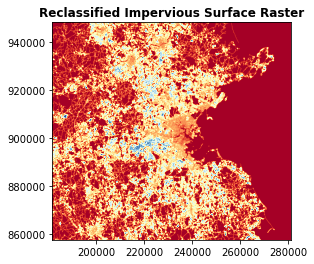

In [102]:
show(impervious_reclass, title="Reclassified Impervious Surface Raster", transform=transform, cmap="RdYlBu")
plt.show()

## Land Cover

## Tree Canopy

## Farmers Markets

## Libraries

## Restaurants

## Resident Age